In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Github/Biometric

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Github/Biometric


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import cv2
from PIL import Image

from FUNC_script import *

In [3]:
# Load FaceNet Model
model = load_model('Template_poisoning/model/facenet_keras.h5', compile= False)
model.trainable= False

In [4]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

def Centroid(vector):
  ''' 
      After the random initialization, we first optimize the
      glasses using the adversary’s centroid in feature space(Xc)
     # Arguments
        Input: feature vector(batch_size x feature)	
    '''
  Xc= tf.math.reduce_mean(vector, axis=0)
  return tf.reshape(Xc, (1, vector.shape[-1]))

In [5]:
# Data  Loading
def load_data(dir):
  X=[]
  for i, sample in enumerate(os.listdir(dir)):
    image= load_img(os.path.join(dir, sample))
    image = cv2.resize(image, (160, 160))
    X.append(image/255.0)
  return np.array(X)

X= load_data('Template_poisoning/Croped_data/adversary_images')
Target_samples= load_data('Template_poisoning/Croped_data/target_images')
X_ex= X.copy() # Copy of X
print('Adversarial Batch:',X.shape)

Adversarial Batch: (24, 160, 160, 3)


In [6]:
# GET Mask
mask= load_img('Template_poisoning/final_mask.png') #Sacle(0-255), RGB
mask= mask/255.0
mask.shape

(160, 160, 3)

In [7]:
# img_tr= load_img('Template_poisoning/Croped_data/target_images/ben_afflek_0.jpg')
# feature_tr= model.predict(img_tr[np.newaxis, :, :, :])
#Target= Generate_target(feature_tr, batch_size= X.shape[0])

Target= Centroid(model.predict(Target_samples))
Target= Generate_target(Target, batch_size= X.shape[0])
Target.shape

(24, 128)

In [8]:
delta_x= np.random.uniform(low=0.0, high=1.0, size=X.shape) # Scale(0-1)
delta_x.shape

(24, 160, 160, 3)

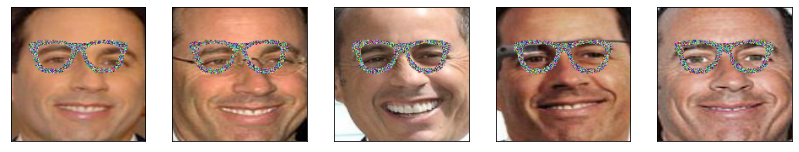

In [9]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
image= X*(1-mask)+ delta_x*mask
for i in range(5):
  ax[i].imshow(image[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()
del image

In [10]:
Xc= Centroid(model.predict(X)) #(1 x 128)
print(Xc.shape)
Xc= Generate_target(Xc, batch_size=24) #(24 x 128)
print(Xc.shape)

(1, 128)
(24, 128)


In [11]:
def loss_object(pred, label, delta= delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))

    vector_mean= tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss

In [12]:
def back_propagate(model, X, mask, delta_x, label, direction= False):
  with tf.GradientTape() as g:
      g.watch(delta_x)
      X_batch= Generate_sample(X, delta_x, mask)
      feature= model(X_batch)
      loss= loss_object(pred= feature, label= label, delta= delta_x, direction= direction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = g.gradient(loss, delta_x)
  return gradient, tf.reduce_mean(loss).numpy()

In [13]:
# Tf Variables
X= tf.Variable(X, dtype=tf.float64)
delta_x= tf.Variable(delta_x, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
Xc= tf.Variable(Xc)

In [14]:
epoch= 151
Lambda= 0.5
for ep  in range(epoch):
  grad, loss= back_propagate(model, X, mask, delta_x, Xc)
  # Gradient step
  delta_x= delta_x - Lambda*grad
  if ep%10 == 0:
    print('Epoch: {}  Loss: {:.3f}'.format((ep+1), loss))

Epoch: 1  Loss: 169.509
Epoch: 11  Loss: 141.182
Epoch: 21  Loss: 116.927
Epoch: 31  Loss: 94.629
Epoch: 41  Loss: 74.289
Epoch: 51  Loss: 56.299
Epoch: 61  Loss: 41.125
Epoch: 71  Loss: 29.337
Epoch: 81  Loss: 21.081
Epoch: 91  Loss: 15.868
Epoch: 101  Loss: 12.682
Epoch: 111  Loss: 10.794
Epoch: 121  Loss: 9.524
Epoch: 131  Loss: 8.747
Epoch: 141  Loss: 8.288
Epoch: 151  Loss: 7.956


In [15]:
Lambda= 0.2
for ep  in range(int(3*epoch)):
  grad, loss= back_propagate(model, X, mask, delta_x, Target, direction= True)
  # Gradient step
  delta_x= delta_x - Lambda*grad
  if ep== 0:
    delta_x0= tf.identity(delta_x)
  if ep== 1:
    delta_x1= tf.identity(delta_x)
  if ep== 2:
    delta_x2= tf.identity(delta_x)
  if ep== 3:
    delta_x2= tf.identity(delta_x)
  if ep== 170:
    Lambda= 0.1
  if ep== 300:
    Lambda= 0.04
  if ep%10 == 0:
    print('Epoch: {}, Loss: {}'.format((ep+1), loss))

Epoch: 1, Loss: 168.56153869628906
Epoch: 11, Loss: 80.95758056640625
Epoch: 21, Loss: 67.60730743408203
Epoch: 31, Loss: 62.83033752441406
Epoch: 41, Loss: 59.26140213012695
Epoch: 51, Loss: 55.555789947509766
Epoch: 61, Loss: 53.79326248168945
Epoch: 71, Loss: 52.915401458740234
Epoch: 81, Loss: 51.31157302856445
Epoch: 91, Loss: 49.903472900390625
Epoch: 101, Loss: 49.534305572509766
Epoch: 111, Loss: 48.8064079284668
Epoch: 121, Loss: 49.36268997192383
Epoch: 131, Loss: 47.68635940551758
Epoch: 141, Loss: 49.1936149597168
Epoch: 151, Loss: 46.83123779296875
Epoch: 161, Loss: 45.9007453918457
Epoch: 171, Loss: 47.2750358581543
Epoch: 181, Loss: 40.81623458862305
Epoch: 191, Loss: 40.38079071044922
Epoch: 201, Loss: 40.14240646362305
Epoch: 211, Loss: 40.02400207519531
Epoch: 221, Loss: 39.84732437133789
Epoch: 231, Loss: 40.0816535949707
Epoch: 241, Loss: 39.6949577331543
Epoch: 251, Loss: 39.871864318847656
Epoch: 261, Loss: 39.7047233581543
Epoch: 271, Loss: 39.42428970336914
Epoc

In [16]:
adv_sample0=Generate_sample(X, delta_x, mask)
adv_sample0=adv_sample0.numpy()


adv_sample1=Generate_sample(X, delta_x1, mask)
adv_sample1=adv_sample1.numpy()
adv_sample1.shape

(24, 160, 160, 3)

In [17]:
adv_sample0=np.clip(adv_sample0, 0, 1)

adv_sample1=np.clip(adv_sample1, 0, 1)

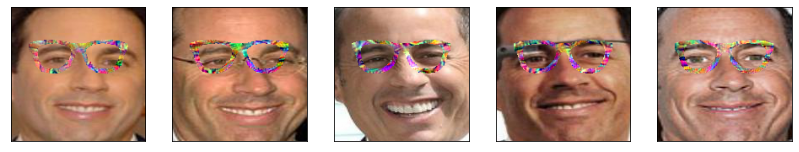

In [18]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
for i in range(5):
  ax[i].imshow(adv_sample0[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()

In [19]:
adv_feature= model.predict(X_ex)
df_adv= pd.DataFrame(adv_feature)

In [20]:
adv_modified_feature0= model.predict(adv_sample0)
df_adv_modify0= pd.DataFrame(adv_modified_feature0)

adv_modified_feature1= model.predict(adv_sample1)
df_adv_modify1= pd.DataFrame(adv_modified_feature1)

In [21]:
target_feature= model.predict(Target_samples)
df_target= pd.DataFrame(target_feature)

In [22]:
df_adv['target']= 'Adversarial_sample'
df_adv_modify0['target']= 'Adversarial Pubertation initial step'
df_adv_modify1['target']= 'Adversarial Pubertation final step'
df_target['target']= 'Target_sample'

df=pd.concat([df_target, df_adv_modify0,df_adv_modify1,  df_adv], ignore_index= True)
df.shape

(85, 129)

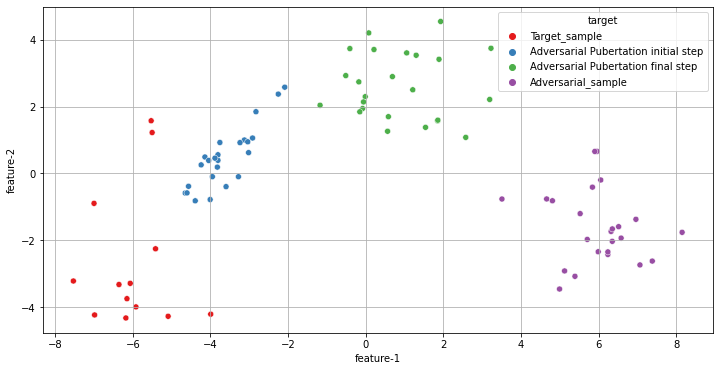

In [47]:
pca = PCA(n_components=2) 
# Fit pca to 'X'
df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1.shape

df1['target']= df.target

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True)
plt.xlabel('feature-1'); plt.ylabel('feature-2')
sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1', ax= ax)
plt.show()